# One Jupyter notebook. From GeoJSON to .xml 

## Imports

In [1]:
import geopandas
import pandas
import numpy
import tifffile
import shapely
# import streamlit as st
from lmd.lib import Collection
from pathlib import Path
import ast
import string

In [2]:
from loguru import logger
import sys
logger.remove()
logger.add(sys.stdout, format="<green>{time:HH:mm:ss.SS}</green> | <level>{level}</level> | {message}")

1

## From GeoJSON to Dataframe

In [3]:
#user defined variables:
path_to_file = '/Users/jnimoca/Desktop/M1_l4_toprightextp3_Composite.geojson'
path_to_save_files = '/Users/jnimoca/Desktop/'
#the naming of these should match exactly the names in the geoJSON file
calibration_points = ['calib1','calib2','calib3']

### Samples and wells

In [3]:
# if you want to pass a custom well loadout use the following dictionary:  
# The dictionary keys will have to be the class name used in qupath, it has to be the exact names.  
# please choose wells with a 2-row 2-column margin. not rows (A, B, N, O) not columns (1,2,23,24)  

In [4]:
samples_and_wells = { 
 '187_HBC_mid_3': 'C3',
 '187_HBC_nVEC_1': 'C4',
 '187_HBC_nVEC_2': 'C5',
 '187_HBC_mid_2': 'C6',
 '187_HBC_nTroph_3': 'C7',
 '187_HBC_nTroph_1': 'C8',
 '187_HBC_mid_1': 'C9',
 '187_HBC_nVEC_3': 'C10',
 '187_HBC_nTroph_2': 'C11',
 '108_STB_nVEC_1': 'F3',
 '108_STB_nVEC_2': 'F4',
 '108_STB_nVEC_3': 'F5',
 '108_STB_gen_1': 'F6',
 '108_STB_gen_2': 'F7',
 '108_STB_gen_3': 'F8',
 '108_CTB_1_1': 'F9',
 '108_CTB_2_1': 'F10',
 '108_CTB_3_1': 'F11',
 '108_HBC_nTroph_1': 'G3',
 '108_HBC_nTroph_2': 'G4',
 '108_HBC_nTroph_3': 'G5',
 '108_HBC_nVEC_1': 'G6',
 '108_HBC_nVEC_2': 'G7',
 '108_HBC_nVEC_3': 'G8',
 '108_HBC_mid_1': 'G9',
 '108_HBC_mid_2': 'G10',
 '108_HBC_mid_3': 'G11',
 '108_CCT_1': 'H3',
 '108_CCT_2': 'H4',
 '108_CCT_3': 'H5',
 '108_VEC_1': 'H6',
 '108_VEC_2': 'H7',
 '108_VEC_3': 'H8',
 '108_Str_1': 'H9',
 '108_Str_2': 'H10',
 '108_Str_3': 'H11',
 '187_STB_nVEC_1': 'D3',
 '187_STB_nVEC_2': 'D4',
 '187_STB_nVEC_3': 'D5',
 '187_STB_gen_1': 'D6',
 '187_STB_gen_2': 'D7',
 '187_STB_gen_3': 'D8',
 '187_CTB_1': 'D9',
 '187_CTB_2': 'D10',
 '187_CTB_3': 'D11',
 '187_CCT_1': 'E3',
 '187_CCT_2': 'E4',
 '187_CCT_3': 'E5',
 '187_VEC_1': 'E6',
 '187_VEC_2': 'E7',
 '187_VEC_3': 'E8',
 '187_str_1': 'E9',
 '187_str_2': 'E10',
 '187_str_3': 'E11'
 }

# Quality Control geojson

In [96]:
def QC_geojson_file(geojson_path: str, list_of_calibpoint_names: list = ['calib1','calib2','calib3']):

    df = geopandas.read_file(geojson_path)
    logger.info(f"Geojson file loaded with shape {df.shape}")
    
    try:
        df['annotation_name'] = df['name']
    except:
        logger.warning('No name column found, meaning no annotation in Qupath was named, at least calibration points should be named')
        sys.exit()

    geometry_counts = df.geometry.geom_type.value_counts()
    log_message = ", ".join(f"{count} {geom_type}s" for geom_type, count in geometry_counts.items())
    logger.info(f"Geometries in DataFrame: {log_message}")

    #check for calibration points
    for point_name in list_of_calibpoint_names:
        if point_name not in df['annotation_name'].unique():
            logger.error(f'Your given annotation_name {point_name} is not present in the file')
            logger.error(f'These are the calib points you passed: {list_of_calibpoint_names}')
            logger.error(f"These are the calib points found in the geojson you gave me: {df[df['geometry'].geom_type == 'Point']['annotation_name']}")

    calib_np_array = numpy.array(
        [[  df.loc[df['name'] == point_name, 'geometry'].values[0].x,
            df.loc[df['name'] == point_name, 'geometry'].values[0].y] 
            for point_name in list_of_calibpoint_names])
    
    def polygon_intersects_triangle(polygon, triangle):
        if isinstance(polygon, shapely.Polygon):
            return polygon.intersects(triangle)
        elif isinstance(polygon, shapely.LineString):
            return polygon.intersects(triangle)
        else:
            return False  # Return False for other geometry types

    df['intersects'] = df['geometry'].apply(lambda x: polygon_intersects_triangle(x, shapely.Polygon(calib_np_array)))

    num_of_polygons_and_LineString = df[df['geometry'].geom_type.isin(['Polygon', 'LineString'])].shape[0]

    intersect_fraction = df['intersects'].sum()/num_of_polygons_and_LineString
    logger.info(f" {intersect_fraction*100:.2f}% of polygons are within calibration triangle")
    if intersect_fraction < 0.25:
        logger.warning(f"Less than 25% of the objects intersect with the calibration triangle")
        logger.warning(f"Polygons will most likely be warped, consider changing calib points")

    #remove points
    df = df[df['geometry'].apply(lambda geom: not isinstance(geom, shapely.geometry.Point))]
    logger.debug(f"Point geometries have been removed")

    #check and remove empty classifications
    if df['classification'].isna().sum() !=0 :
        logger.info(f"You have {df['classification'].isna().sum()} NaNs in your classification column")
        logger.info(f"These are unclassified objects from Qupath, they will be removed")
        df = df[df['classification'].notna()]

    #rename classification
    df['classification_name'] = df['classification'].apply(lambda x: x.get('name'))

    logger.debug(f"Checking for MultiPolygon objects")
    if 'MultiPolygon' in df.geometry.geom_type.value_counts().keys():
        logger.debug(f"MultiPolygon objects present:  {df.geometry.geom_type.value_counts()['MultiPolygon']}")
        logger.debug(f"These are not supported, and will be removed")
        df = df[df.geometry.geom_type != 'MultiPolygon']
    
    def extract_coordinates(geometry):
        if geometry.geom_type == 'Polygon':
            return [list(coord) for coord in geometry.exterior.coords]
        elif geometry.geom_type == 'LineString':
            return [list(coord) for coord in geometry.coords]
        else:
            return None 

    logger.debug(f"Extracting coordinates from geometries")
    df['coords'] = df.geometry.simplify(1).apply(extract_coordinates)

    logger.success(f"QC of geojson file complete")

# Setup geojson processing

In [52]:
def load_geojson_file(geojson_path: str, list_of_calibpoint_names: list = ['calib1','calib2','calib3']):

   df = geopandas.read_file(geojson_path)

   calib_np_array = numpy.array(
      [[ df.loc[df['name'] == point_name, 'geometry'].values[0].x,
         df.loc[df['name'] == point_name, 'geometry'].values[0].y] 
         for point_name in list_of_calibpoint_names])

   df = df[df['geometry'].apply(lambda geom: not isinstance(geom, shapely.geometry.Point))]
   
   if df['classification'].isna().sum() !=0 :
      df = df[df['classification'].notna()]
   if 'MultiPolygon' in df.geometry.geom_type.value_counts().keys():
      df = df[df.geometry.geom_type != 'MultiPolygon']

   def extract_coordinates(geometry):
      if geometry.geom_type == 'Polygon':
         return [list(coord) for coord in geometry.exterior.coords]
      elif geometry.geom_type == 'LineString':
         return [list(coord) for coord in geometry.coords]
      else:
         return None 

   df['coords'] = df.geometry.simplify(1).apply(extract_coordinates)
   df['Name'] = df['classification'].apply(lambda x: x.get('name'))

   return df, calib_np_array

In [35]:
def create_list_of_acceptable_wells():
    list_of_acceptable_wells =[]
    for row in list(string.ascii_uppercase[1:14]):
        for column in range(2,22):
            list_of_acceptable_wells.append(str(row) + str(column))
    return list_of_acceptable_wells

In [34]:
def create_default_samples_and_wells(df):
    list_of_acceptable_wells = create_list_of_acceptable_wells()
    samples_and_wells = {}
    for sample in df["Name"]:
        samples_and_wells[sample] = list_of_acceptable_wells.pop(0)
    return samples_and_wells

In [41]:
def load_and_QC_SamplesandWells(samples_and_wells_input):

   samples_and_wells_processed = samples_and_wells_input.replace("\n", "")
   samples_and_wells_processed = samples_and_wells_processed.replace(" ", "")
   samples_and_wells = ast.literal_eval(samples_and_wells_processed)

   # check if the wells are in the list of acceptable wells
   for key, value in samples_and_wells.items():
      if value not in create_list_of_acceptable_wells():
         logger.error(f"Your well {value} for sample {key} is not in the list of acceptable wells")
         logger.error(f"Please choose wells that are not rows (A,O) not columns (1,22,23,24)")
         sys.exit()

In [37]:
def sample_placement_384wp(samples_and_wells):
    #create and export dataframe with sample placement in 384 well plate
    rows_A_P= [i for i in string.ascii_uppercase[:16]]
    columns_1_24 = [str(i) for i in range(1,25)]
    df_wp384 = pandas.DataFrame('',columns=columns_1_24, index=rows_A_P)
    #fill in the dataframe with samples and wells
    for i in samples_and_wells:
        location = samples_and_wells[i]
        df_wp384.at[location[0],location[1:]] = i
    #save dataframe as csv
    df_wp384.to_csv(f"./384_wellplate.csv", index=True)

In [39]:
def create_collection(df, calib_np_array, samples_and_wells=None):

    # if no samples and wells are given, create default samples and wells
    if samples_and_wells == None:
        samples_and_wells = create_default_samples_and_wells(df)

    the_collection = Collection(calibration_points = calib_np_array)
    the_collection.orientation_transform = numpy.array([[1,0 ],[0,-1]])
    for i in df.index:
        the_collection.new_shape(df.at[i,'coords'], well = samples_and_wells[df.at[i, "Name"]])

    sample_placement_384wp(samples_and_wells)

    the_collection.plot(save_name= "./TheCollection.png")
    the_collection.save(f"./LMD_ready_contours.xml")

# Check geojsons

In [42]:
paths = []
for path in Path("/Users/jnimoca/Desktop/qupath").rglob("*.geojson"):
    paths.append(path)

### M1_right_3exp7

12:50:56.42 | INFO | Geojson file loaded with shape (95, 5)
12:50:56.43 | INFO | Geometries in DataFrame: 73 Polygons, 19 LineStrings, 3 Points
12:50:56.43 | INFO |  21.74% of polygons are within calibration triangle
12:50:56.43 | WARNING | Less than 50% of the objects intersect with the calibration triangle
12:50:56.43 | WARNING | Polygons will most likely be warped, consider changing calib points
12:50:56.43 | DEBUG | Point geometries have been removed
12:50:56.43 | DEBUG | Checking for MultiPolygon objects
12:50:56.43 | DEBUG | Extracting coordinates from geometries
12:50:56.44 | SUCCESS | QC of geojson file complete


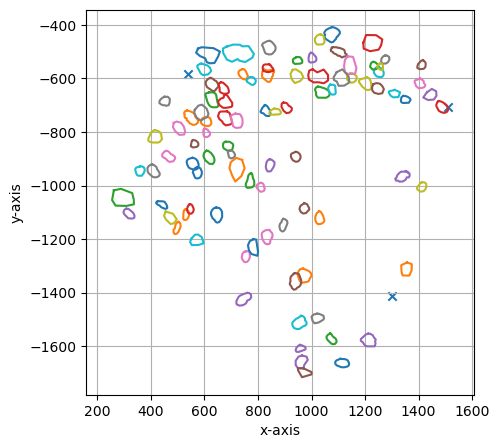

[ 129869. -141420.]
[151034. -70722.]
[ 53761. -58417.]


In [91]:
QC_geojson_file(paths[0], calibration_points)
df, calib_np_array = load_geojson_file(paths[0], calibration_points)
create_collection(df, calib_np_array, samples_and_wells)

### M1_l4

12:53:19.72 | INFO | Geojson file loaded with shape (97, 5)
12:53:19.72 | INFO | Geometries in DataFrame: 85 Polygons, 9 LineStrings, 3 Points
12:53:19.73 | INFO |  4.26% of polygons are within calibration triangle
12:53:19.73 | WARNING | Less than 25% of the objects intersect with the calibration triangle
12:53:19.73 | WARNING | Polygons will most likely be warped, consider changing calib points
12:53:19.73 | DEBUG | Point geometries have been removed
12:53:19.73 | DEBUG | Checking for MultiPolygon objects
12:53:19.73 | DEBUG | Extracting coordinates from geometries
12:53:19.74 | SUCCESS | QC of geojson file complete


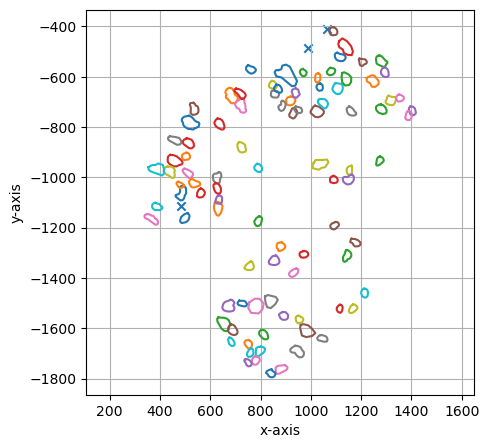

[106493. -41066.]
[  48530. -111332.]
[ 98833. -48752.]


In [99]:
QC_geojson_file(paths[1], calibration_points)
df, calib_np_array = load_geojson_file(paths[1], calibration_points)
create_collection(df, calib_np_array, samples_and_wells)

### M1_Right_5exp11_Composite

12:53:13.73 | INFO | Geojson file loaded with shape (37, 5)
12:53:13.73 | INFO | Geometries in DataFrame: 25 Polygons, 9 LineStrings, 3 Points
12:53:13.74 | INFO |  17.65% of polygons are within calibration triangle
12:53:13.74 | WARNING | Less than 25% of the objects intersect with the calibration triangle
12:53:13.74 | WARNING | Polygons will most likely be warped, consider changing calib points
12:53:13.74 | DEBUG | Point geometries have been removed
12:53:13.74 | DEBUG | Checking for MultiPolygon objects
12:53:13.74 | DEBUG | Extracting coordinates from geometries
12:53:13.74 | SUCCESS | QC of geojson file complete


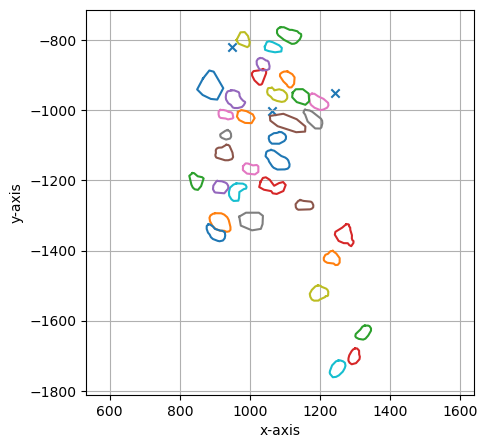

[124203. -94969.]
[ 94975. -81806.]
[ 106360. -100305.]


In [97]:
QC_geojson_file(paths[2], calibration_points)
df, calib_np_array = load_geojson_file(paths[2], calibration_points)
create_collection(df, calib_np_array, samples_and_wells)

### M1_Right_2exp5_Composite

12:53:16.02 | INFO | Geojson file loaded with shape (56, 5)
12:53:16.02 | INFO | Geometries in DataFrame: 42 Polygons, 11 LineStrings, 3 Points


12:53:16.02 | INFO |  7.55% of polygons are within calibration triangle
12:53:16.02 | WARNING | Less than 25% of the objects intersect with the calibration triangle
12:53:16.02 | WARNING | Polygons will most likely be warped, consider changing calib points
12:53:16.03 | DEBUG | Point geometries have been removed
12:53:16.03 | DEBUG | Checking for MultiPolygon objects
12:53:16.03 | DEBUG | Extracting coordinates from geometries
12:53:16.03 | SUCCESS | QC of geojson file complete


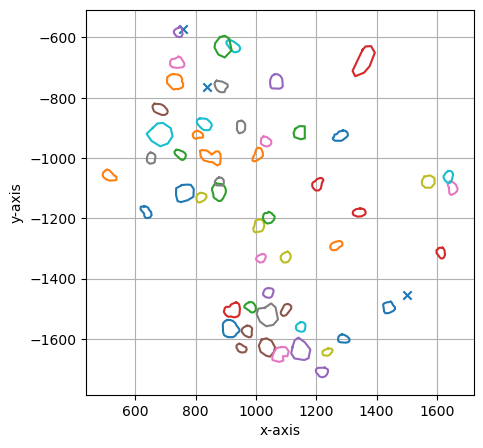

[ 83727. -76486.]
[ 75849. -57263.]
[ 150152. -145447.]


In [98]:
QC_geojson_file(paths[3], calibration_points)
df, calib_np_array = load_geojson_file(paths[3], calibration_points)
create_collection(df, calib_np_array, samples_and_wells)